In [1]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# importing required libraries
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import pickle
import re
from nltk.corpus import words
from nltk.stem import PorterStemmer

import nltk
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [3]:
# reading data from CSV file
csv_file_path = "/content/drive/MyDrive/Conversation.csv"
df = pd.read_csv(csv_file_path)

# extracting questions and answers from the CSV file
questions = df['question'].tolist()
answers = df['answer'].tolist()


In [4]:
# Preprocess and prepare the data
# Text preprocessing steps

# Text Lowercasing
questions = [q.lower() for q in questions]

# Text Normalization
def normalize_text(text):
    # Replace "u" with "you"
    text = re.sub(r"\bu\b", "you", text)
    # Replace "gr8" with "great"
    text = re.sub(r"\bgr8\b", "great", text)
    return text

questions = [normalize_text(q) for q in questions]


In [5]:
# Spell Checking
def spell_check(text):
    # Check if words are spelled correctly
    spell = words.words()
    corrected_text = []
    for word in text.split():
        if word in spell:
            corrected_text.append(word)
        else:
            # Handle spelling correction logic here
            corrected_text.append(word)  # using nltk library for spell-checking
    return " ".join(corrected_text)

questions = [spell_check(q) for q in questions]

# Handling Contractions
def expand_contractions(text):
    contractions = {
        "can't": "cannot",
        "don't": "do not",
        # can add more contractions and their expansions
    }
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    return text

questions = [expand_contractions(q) for q in questions]

# Stemming
stemmer = PorterStemmer()
questions = [" ".join([stemmer.stem(word) for word in q.split()]) for q in questions]


In [6]:
# Tokenization
vocab_size = 1000
embedding_dim = 16
max_len = 20
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(questions)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(questions)
padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len)


In [7]:
# Encoding the answers
lbl_encoder = LabelEncoder()
lbl_encoder.fit(answers)
encoded_answers = lbl_encoder.transform(answers)


In [8]:
# Build a neural network model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(len(answers), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [9]:
# Summary of the model
model.summary()

# Train the model
epochs = 500
history = model.fit(padded_sequences, np.array(encoded_answers), epochs=epochs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 16)            16000     
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 3725)              63325     
                                                                 
Total params: 79869 (311.99 KB)
Trainable params: 79869 (311.99 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [10]:
# Save the trained model
model.save("chat_model")

# Save the fitted tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the fitted label encoder
with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(lbl_encoder, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)


In [11]:
# Load the trained model, tokenizer, and label encoder
model = keras.models.load_model('chat_model')
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
with open('label_encoder.pickle', 'rb') as enc:
    lbl_encoder = pickle.load(enc)


In [12]:
# colorama for colored text
!pip install colorama


In [13]:
import colorama
from colorama import Fore, Style

colorama.init()

print(Fore.GREEN + "Start messaging with the bot (type quit to stop)!" + Style.RESET_ALL)

# Interaction with the Chatbot
while True:
    print("User: ", end="")
    user_input = input()

    if user_input.lower() == "quit":
        break

    # Preprocess user input
    user_input = user_input.lower()
    user_input = normalize_text(user_input)
    user_input = spell_check(user_input)
    user_input = expand_contractions(user_input)
    user_input = " ".join([stemmer.stem(word) for word in user_input.split()])

    # Predict the response
    user_sequence = tokenizer.texts_to_sequences([user_input])
    user_padded = pad_sequences(user_sequence, truncating='post', maxlen=max_len)
    predicted_encoded_response = model.predict(user_padded)
    predicted_response = lbl_encoder.inverse_transform([np.argmax(predicted_encoded_response)])

    print(Fore.GREEN + "ChatBot:", predicted_response[0] + Style.RESET_ALL)

print(Fore.RED + "ChatBot session ended." + Style.RESET_ALL)


Start messaging with the bot (type quit to stop)!
User: hi, how are you doing?
1/1 [==============================] - 0s 207ms/step
ChatBot: i'm fine. how about yourself?
User: what school do you go to?
1/1 [==============================] - 0s 23ms/step
ChatBot: i'm having dinner with my family
User: i go to pcc
1/1 [==============================] - 0s 25ms/step
ChatBot: do you like it there?
User: good luck with school.
1/1 [==============================] - 0s 30ms/step
ChatBot: thank you very much.
User: good luck with that
1/1 [==============================] - 0s 25ms/step
ChatBot: thanks.
User: quit
ChatBot session ended.


24/24 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


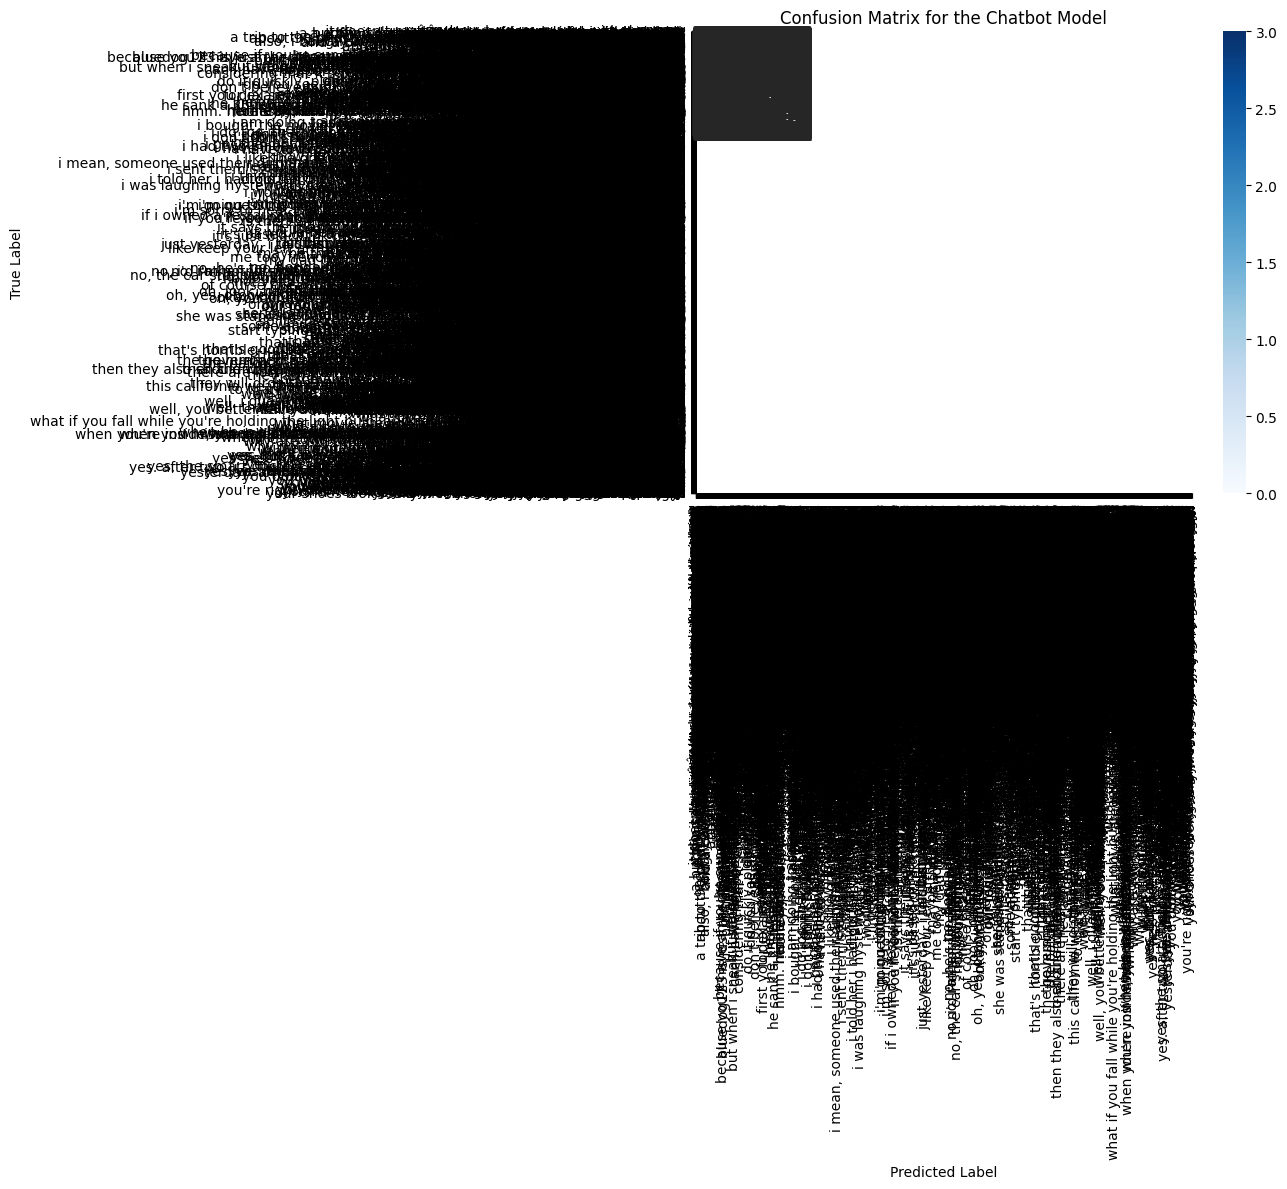

Accuracy: 0.8456
Precision: 0.8308
Recall: 0.8456
F1 Score: 0.8349


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.


Classification Report:
              precision    recall  f1-score   support

           8       1.00      1.00      1.00         1
          18       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         1
          29       1.00      1.00      1.00         1
          33       1.00      1.00      1.00         1
          36       1.00      1.00      1.00         1
          40       0.00      0.00      0.00         1
          45       0.50      1.00      0.67         1
          46       1.00      1.00      1.00         1
          51       1.00      1.00      1.00         1
          53       1.00      1.00      1.00         1
          57       1.00      1.00      1.00         1
          66       1.00      1.00      1.00         1
          67       1.00      1.00      1.00         1
          68       1.00      1.00      1.00         1
          69       1.00      1.00      1.00         1
          70       1.00      1.00      1.00         1
   

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# The model
model = keras.models.load_model('chat_model')

# Splitting the data into training and test sets
train_size = int(0.8 * len(questions))
train_questions, test_questions = questions[:train_size], questions[train_size:]
train_answers, test_answers = answers[:train_size], answers[train_size:]

# Preprocess and prepare the test data
test_questions = [q.lower() for q in test_questions]
test_questions = [normalize_text(q) for q in test_questions]
test_questions = [spell_check(q) for q in test_questions]
test_questions = [expand_contractions(q) for q in test_questions]
test_questions = [" ".join([stemmer.stem(word) for word in q.split()]) for q in test_questions]

test_sequences = tokenizer.texts_to_sequences(test_questions)
test_padded = pad_sequences(test_sequences, truncating='post', maxlen=max_len)
encoded_test_answers = lbl_encoder.transform(test_answers)

# Evaluation on the test set
test_predictions = model.predict(test_padded)
predicted_labels = np.argmax(test_predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(encoded_test_answers, predicted_labels)
precision = precision_score(encoded_test_answers, predicted_labels, average='weighted')
recall = recall_score(encoded_test_answers, predicted_labels, average='weighted')
f1 = f1_score(encoded_test_answers, predicted_labels, average='weighted')

# Confusion Matrix
cm = confusion_matrix(encoded_test_answers, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=lbl_encoder.classes_, yticklabels=lbl_encoder.classes_)
plt.title("Confusion Matrix for the Chatbot Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
class_report = classification_report(encoded_test_answers, predicted_labels)
print("\nClassification Report:")
print(class_report)
